<a href="https://colab.research.google.com/github/di-wu-dw/teamA-grebes-NMA2020/blob/master/20200720_DW_TemporalFilter_GaussianGLM_allNeurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [37]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [38]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [39]:
def make_design_matrix(stim, d=20):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  pad = round(d/2)
  padded_stim = np.concatenate([np.zeros(pad-1), stim, np.zeros(pad)])

  # Construct a matrix where each row has the d frames of
  # the stimulus proceeding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
  X = np.zeros((T, d))
  
  for t in range(T):
      X[t] = padded_stim[t:t+d]

  return X

def plot_time_filter(theta, dt, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()

  """
  d = len(theta)
  t = np.arange(-round(d/2) + 1, round(d/2)+1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time relative to Run (s)",
    ylabel="Filter weight",
  )


In [40]:
training_len = 5000
theta_lg_store = np.zeros((11983,time_duration))
time_duration = 26 #total duration of temporal filter, with half before, and half after running output

for neuron_idx in range(0,11983):

  X = dat['sresp'][neuron_idx,:training_len]
  y = [x[0] for x in dat['run']][:training_len]


  X_dm = make_design_matrix(X,d=time_duration)
  constant = np.ones_like(y)
  X_dm = np.column_stack([constant, X_dm])

  # Get the MLE weights for the LG model
  theta = np.linalg.inv(X_dm.T @ X_dm) @ X_dm.T @ y
  theta_lg = theta[1:]

  theta_lg_store[neuron_idx,:] = theta_lg

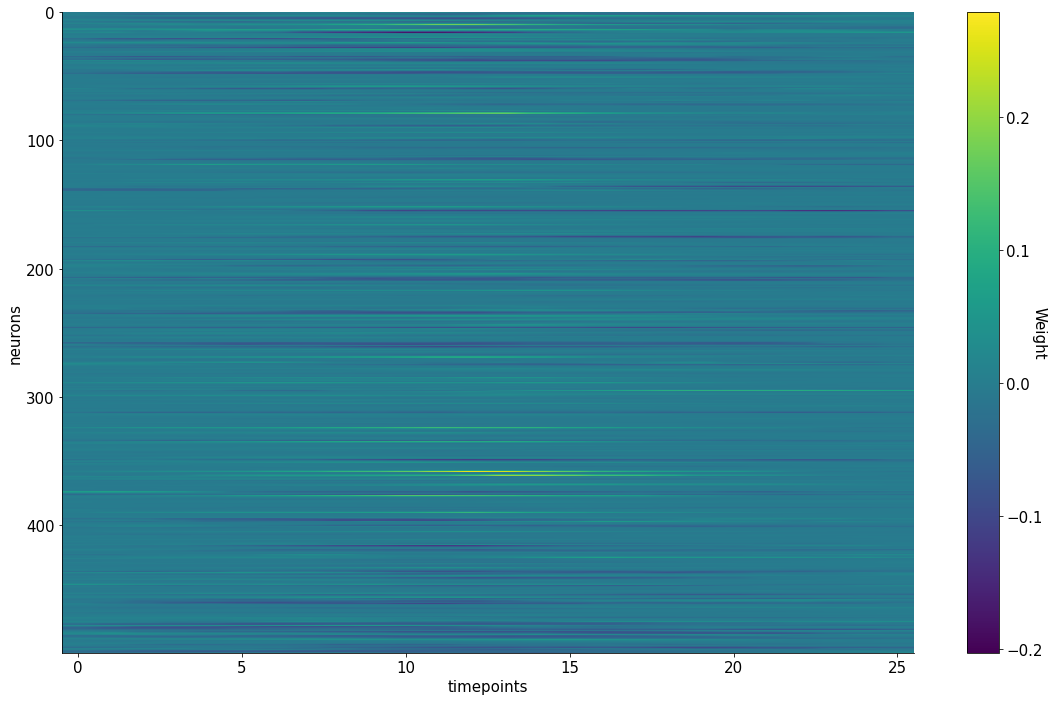

In [41]:
#N = 11983 # number of neurons for plotting
N = 500 # number of neurons for plotting

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(theta_lg_store[:N,:], aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Weight', rotation=270)

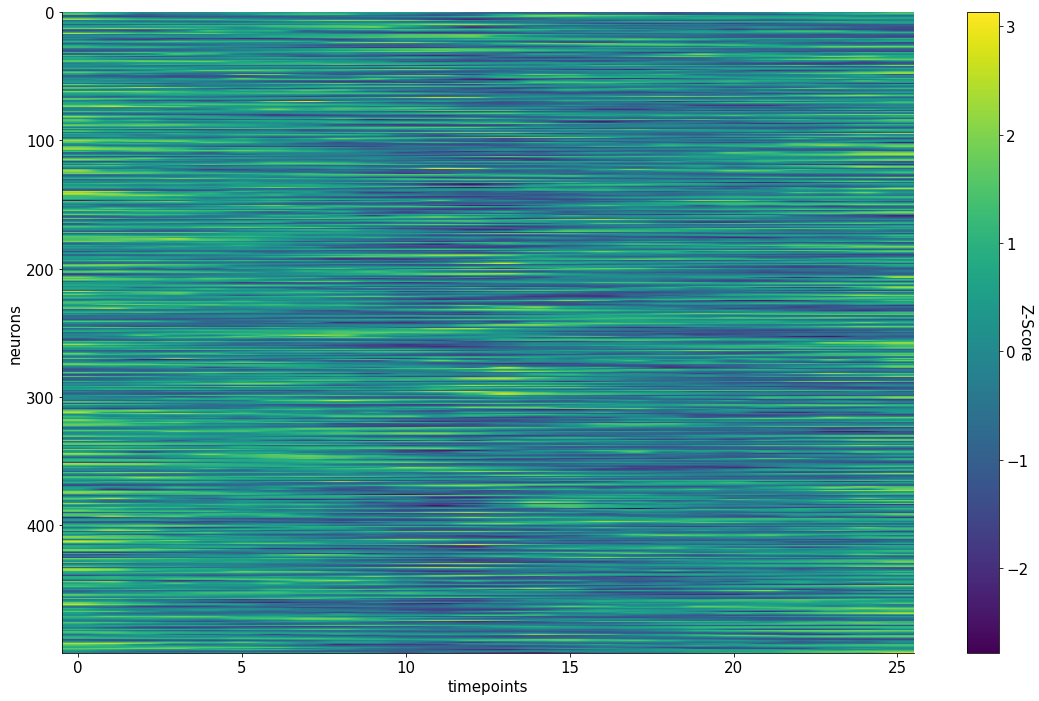

In [42]:
from scipy.stats import zscore

theta_zscore = zscore(theta_lg_store, axis=1)

#N = 11983 # number of neurons for plotting
N = 500 # number of neurons for plotting

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(theta_zscore[:N,:], aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

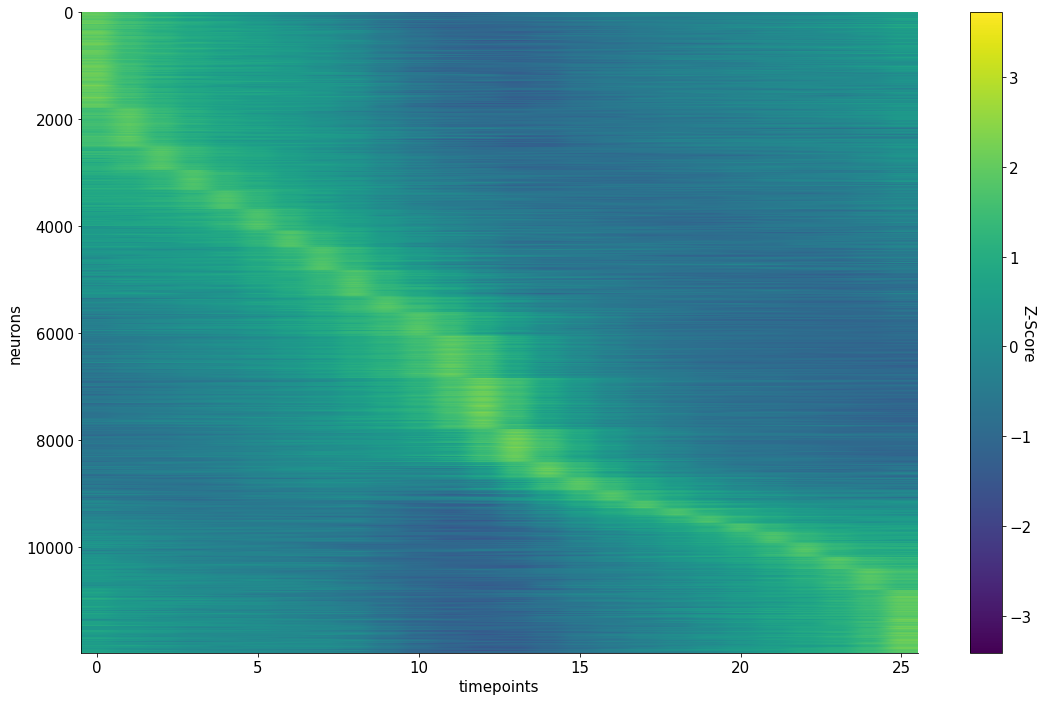

In [43]:
s = np.argmax(theta_zscore,1)
s = sorted(range(len(s)), key=lambda k: s[k])


plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(theta_zscore[s,:], aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

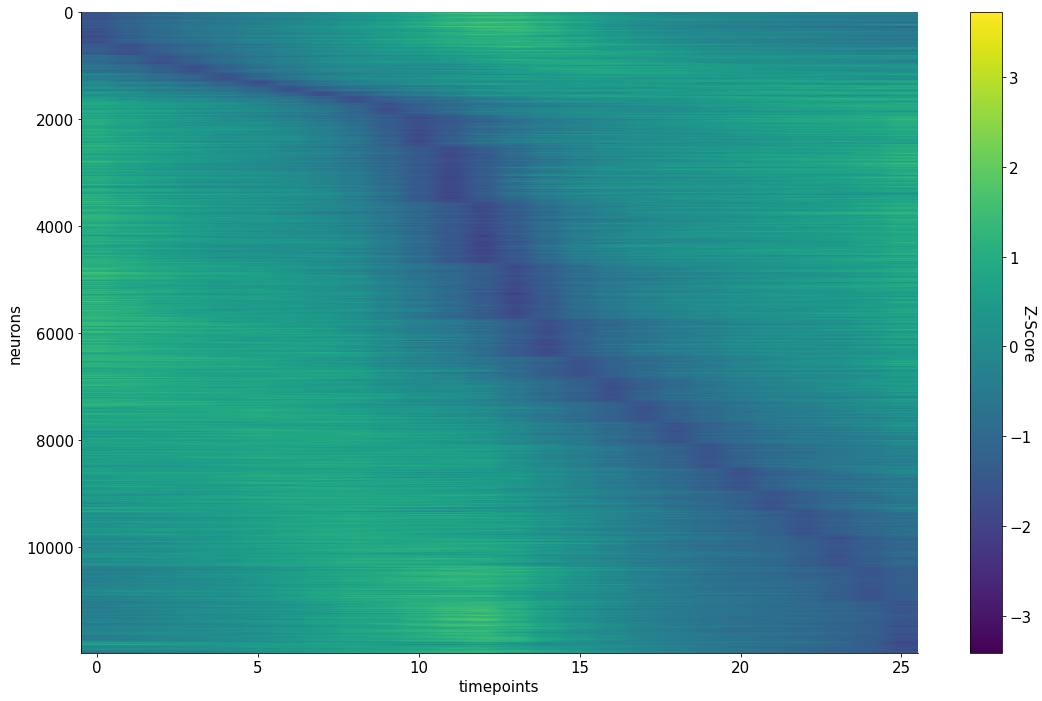

In [44]:
s = np.argmin(theta_zscore,1)
s = sorted(range(len(s)), key=lambda k: s[k])

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(theta_zscore[s,:], aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

In [45]:
# embed = UMAP(n_components=ncomp, init =  theta_zscore, n_neighbors = 20, 
#              metric = 'correlation', transform_seed = 42).fit_transform(theta_lg_store)

# from scipy.ndimage import uniform_filter1d
# embed = embed.flatten()
# isort = np.argsort(embed)
# RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
# RasterMap = zscore(RasterMap[::10, :], axis = 1)

[Text(0, 0.5, 'Mean Weights'), Text(0.5, 0, 'Mean Ca2+ Activity')]

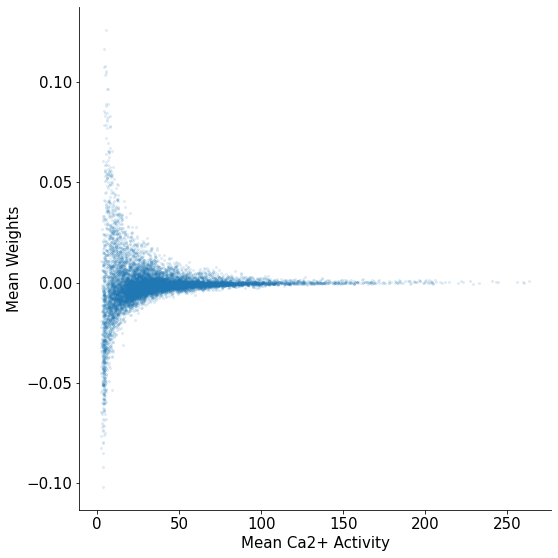

In [52]:
X = dat['sresp'][:,:training_len]
X_mean = np.mean(X,axis=1)
weight_mean = np.mean(theta_lg_store, axis = 1)

plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
plt.scatter(X_mean,weight_mean,s = 4, alpha = .1)
ax.set(xlabel = 'Mean Ca2+ Activity', ylabel = 'Mean Weights')